In [73]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
import pandas as pd
import pylab as plt
import pystan
import seaborn as sns
import numpy as np
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

![](../assets/DJlogo_alpha.png?raw=true)<!-- .element height="80%" width="80%" -->

<http://www.DataJavelin.com>
## Dr Peter Hurley 

## Understanding what Stan is doing

Sampling from the Posterior using Hamiltonian Monte Carlo


### Hamiltonian physics
$$ 
H = T + V 
$$
* $T = \frac{p^2}{2m}$ kinetic energy
* $V=V(q)$ potential energy
* $H$ total energy of system (conserved)
Hamiltonian mechanics can be used to describe systems where energy changes from kinetic to potential and back again over time


### Hamiltonian Monte carlo
* Potential energy = Posterior probability distribution


### [HMC simulation](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=banana)
* Doesn't get stuck as using gradient
* BUT extra variables (momentum and energy) which provide useful diagnostics
* Requires:
    * gradients: curvature of log posterior (uses autodifferentation)
    * 'mass' of particle
    * Number of leaps 
    * Size of individual leaps
   


### What gets tuned
* Number of leaps
* Size of steps

Problem: If you choose badly, you get back close to where you were i.e. inefficient

### [NUTS](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana): No U turn sampler
* Warm up phase to work out parameters
* Runs both backwards and forwards and estimates where it is turning around
* Picks parameters that optimise this behaviour

![](./assets/HMC.png)

## Other things to think about:
* How many chains?
* How many iterations?

# When things go wrong


![](../assets/roller-coaster-clipart-black-and-white-1.jpg?raw=true)<!-- .element height="80%" width="80%" -->

### Divergent transitions
**coming off the roller coaster track**

* Energy hasn't been conserved
* Physics approximation no longer valid
* our samples are not properly sampling posterior

The leap frog steps are a numerical approximation, not a smooth simulation

* If they are too big or rollercoaster changes violently then the approximation will fail, energy not conserved.

**BUT**: We diagnosing it is good. Other MCMC technqiues will also fail in same circumstances but you won't know

![](../assets/roller-coaster-clipart-black-and-white-good.jpg?raw=true)<!-- .element height="80%" width="80%" -->

![](../assets/roller-coaster-clipart-black-and-white-bad.jpg?raw=true)<!-- .element height="80%" width="80%" -->

### Example

In [75]:
V=np.random.normal(0,3,10000)
x=np.random.normal(0,np.exp(V),10000)

(-500, 500)

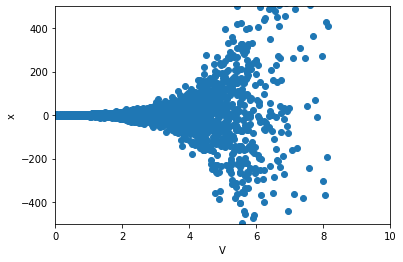

In [79]:
plt.scatter(V,x)
plt.xlabel('V')
plt.ylabel('x')
plt.xlim(0,10)
plt.ylim(-500,500)

In [81]:
model="""
data{
real mu_V;
real<lower=0.0> sig_V;
real mu_x;
}
parameters {
real V;
real x;
}

model {

V~normal(mu_V,sig_V);
x~normal(0,exp(V));
}
"""

In [82]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a68d63213d4f4514b96ae981dbe942dc NOW.


In [83]:
data={
    'mu_V':0,
    'sig_V':3,
    'mu_x':0
}

In [84]:
fit=sm.sampling(data=data)

In [85]:
fit

Inference for Stan model: anon_model_a68d63213d4f4514b96ae981dbe942dc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
V      3.31    0.63   1.94  -0.54   2.29    3.3   4.21   7.71      9   1.21
x    123.14  147.28 1555.8 -595.3 -11.14  -0.04  17.38 687.28    112   1.03
lp__  -4.57    0.75    2.8 -11.55  -5.71  -4.31  -3.01   0.16     14   1.16

Samples were drawn using NUTS at Fri Jul 31 10:38:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [86]:
pystan.diagnostics.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

Text(0, 0.5, 'x')

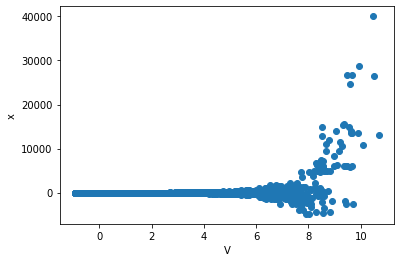

In [87]:
plt.scatter(fit['V'],fit['x'])
plt.xlabel('V')
plt.ylabel('x')

### Investigating where the divergent transitions are occuring

In [88]:
samp_params=fit.get_sampler_params(inc_warmup=False)

In [89]:
samp_params[0].keys()

odict_keys(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'])

In [97]:
div=np.concatenate([samp_params[i]['divergent__'] for i in range(0,len(samp_params))])


(4000,)

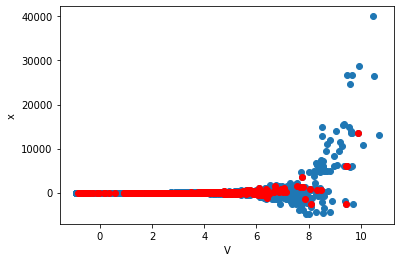

In [100]:
plt.scatter(fit['V'],fit['x'])
plt.xlabel('V')
plt.ylabel('x')


plt.scatter(fit['V'][div.astype(bool)],fit['x'][div.astype(bool)],c='r')


### How to solve: Increase `adapt delta`

In [102]:
fit=sm.sampling(data=data,control=dict(adapt_delta=0.95))

### How to solve: Non-centred parameterisation

This is our problem:
$$
V \sim Normal(0,3)
$$
$$
x \sim Normal(0,exp(V))
$$


Think about other ways of expressing/rearranging parameters in a Normal distribution:
$$ 
\alpha \sim Normal(\mu, \sigma)
$$

$$ 
\alpha = \mu + \beta
$$
$$
\beta \sim Normal(0,sigma)
$$

$$ \alpha = \mu + z\sigma$$
$$z \sim Normal(0,1)$$
This is what we call a non-centred parameterisation

**Exercise convince yourself with `numpy`**
i.e. 
* sample from a normal distribution with $\mu=5$ and $\sigma=2$
* sample from a standard normal, multiply by $\sigma$ and add $\mu$
* Plot the two distributions against each other



In [103]:
s1=np.random.normal(5,2,1000)
s2=np.random.normal(0,1,1000)
s1_nc=5+2*s2

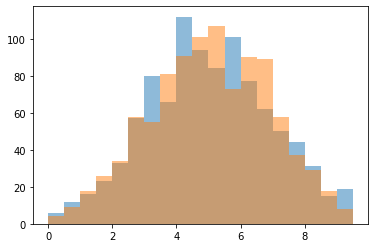

In [107]:
plt.hist(s1,bins=np.arange(0,10,0.5),alpha=0.5);
plt.hist(s1_nc,bins=np.arange(0,10,0.5),alpha=0.5);

#### Back to our Stan model
Our model becomes:
$$ V \sim Normal(0,3) $$
$$ z \sim Normal(0,1) $$
$$x=z\exp(V)+\mu$$

**Exercise**: Write this new model in Stan and sample from it

In [108]:
model="""
data{
real mu_V;
real<lower=0.0> sig_V;
real mu_x;
}
parameters {
real V;
real z;
}

transformed parameters {
real x;
x=mu_x+z*exp(V);
} 
model {
V~normal(mu_V,sig_V);
z~normal(0,1);
}
"""

In [109]:
nc_sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4cbc3ac36f3a1d110fc091be8c133d93 NOW.


In [110]:
nc_fit=nc_sm.sampling(data=data)

In [111]:
nc_fit

Inference for Stan model: anon_model_4cbc3ac36f3a1d110fc091be8c133d93.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
V      0.01    0.05   3.07  -5.96  -1.99  8.2e-3   2.09   6.04   3534    1.0
z     -0.03    0.02    1.0  -1.97   -0.7   -0.03   0.66   1.95   3775    1.0
x    -58.75   31.54 1952.5 -122.5  -0.66 -1.1e-3    0.5  71.65   3831    1.0
lp__  -1.02    0.02   1.01  -3.73   -1.4   -0.73   -0.3  -0.03   1812    1.0

Samples were drawn using NUTS at Fri Jul 31 11:07:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [112]:
pystan.diagnostics.check_hmc_diagnostics(nc_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

### Why does this work
Think about the parameters Stan is actually sampling (walking around)

Text(0, 0.5, 'z')

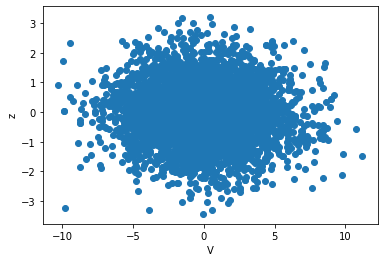

In [113]:
plt.scatter(nc_fit['V'],nc_fit['z'])
plt.xlabel('V')
plt.ylabel('z')

Text(0, 0.5, 'x')

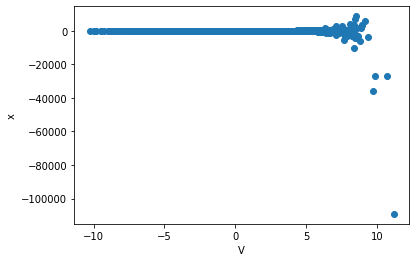

In [114]:
plt.scatter(nc_fit['V'],nc_fit['x'])
plt.xlabel('V')
plt.ylabel('x')

This trick is particularly useful when dealing with hierarchical models

### Maximum Tree Depth
* Not as serious
* Hitting maximum tree depth will effect efficiency not validity of posterior

Think back to NUTs and how it runs forward and backwards until it reaches a point where it is turning around. 

If the tree depth is reached, it means it hasn't been able to run the simulation long enough before it is turning around.

We will see this problem when looking at an example in QR decomposition

### BFMI Low
Bayesian Fraction of Missing Information (BFMI). 

It is a measure of how efficiently each chain is exploring the posterior distribution

A ratio of: energy distribution induced my momentum resampling over marginal energy distribution

Can be betweeen 0 and 1

*  greater than 0.2 ok
* less than 0.2 bad

See [https://arxiv.org/abs/1604.00695](https://arxiv.org/abs/1604.00695) for a detailed explanation.

Think about BFMI as momentum. If you have a long tailed posterior, you need a lot of momentum for particle to get there. HMC tends to use a Gaussian momentum proposal and it won't be able to provide enough momentum to explore tail.

[**From Stan website**](https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded)
> Recommendations:

> * Look at the pairs plot to see which primitive parameters are correlated with the energy__ margin. There should be a negative relationship between lp__ and energy__ in the pairs plot, which is not a concern because lp__ is the logarithm of the posterior kernel rather than a primitive parameter.

> * Reparameterize your model. The primitive parameters that are correlated with the energy__ margin in the pairs plot are a good place to start thinking about reparameterizations.

> * You might try setting a higher value for the iter and / or warmup arguments. By default warmup is half of iter and iter is 2000 by default.
